# Automatic cycling route generator
Please see [this article](https://medium.com/p/16a266d468a5/edit) for more informations

## Install all non built-in packages
#### ... and import them

In [2]:
!pip install pygeos==0.10.2
!pip install geopandas==0.9.0
!pip install osmnx==1.1.1
!pip install SRTM.py==0.3.7
!pip install scikit-optimize
!pip install matplotlib==3.1.3

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 994 kB 5.4 MB/s 
     |████████████████████████████████| 16.7 MB 393 kB/s 
     |████████████████████████████████| 6.3 MB 50.5 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 11.2 MB 34.5 MB/s 
     |████████████████████████████████| 1.0 MB 48.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 900 kB 50.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following

     |████████████████████████████████| 99 kB 3.4 MB/s 
  Created wheel for SRTM.py: filename=SRTM.py-0.3.7-py3-none-any.whl size=105861 sha256=37d8254ee496a89d53b0c8b19b61d1151fcc02ac55cb8c3152cbed1dcd6b416b
  Stored in directory: /root/.cache/pip/wheels/f4/c7/b2/2469a4747bd19d3af08be5cada09cda02c00f29d472e9e3461
Successfully built SRTM.py
     |████████████████████████████████| 100 kB 3.6 MB/s 
     |████████████████████████████████| 13.1 MB 4.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import srtm
import time
import matplotlib.pyplot as plt
import collections

%matplotlib inline
plt.style.use('dark_background')
ox.config(log_console=True)
print(f'osmnx version: {ox.__version__}')
elevation_data = srtm.get_data()    # instanciate srtm.py

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


osmnx version: 1.1.1


## We need to choose a point that will begin and end our cycling loop
#### Just use [google map](https://www.google.fr/maps) and copy/pasta 🍝 latitude and longitude (Geographic coordinate system) into *our_spot* variable

In [10]:
our_spot = (5.784778, -75.505111)                                                                                       # our spot ! (latitude between -90 et 90, longitude between -180 et 180)

# Option A : Download GPS datas from this spot + a certain distance
sqr_dist = 30  # kms                                                                                                    # takes few minutes to download for 20 Kms square
G = ox.graph_from_point(our_spot, dist=sqr_dist*1000, network_type='bike')                                              # This line will download datas from osmx given a (lat, lon) gps point and a square distance
ox.io.save_graphml(G, filepath='map_1.graphml', gephi=False, encoding='utf-8')                                          # save graph as map_1.graphml for later if needed

G = ox.add_edge_speeds(G)                                                                                               # impute speed on all edges missing data
G = ox.add_edge_travel_times(G)                                                                                         # calculate travel time (seconds) for all edges

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)                                                      # Go with GeoPandas GeoDataFrames

gps_x_min, gps_x_max = min(gdf_nodes['x'])+0.000001, max(gdf_nodes['x'])-0.000001
gps_y_min, gps_y_max = min(gdf_nodes['y'])+0.000001, max(gdf_nodes['y'])-0.000001
print(f'gps coord limits: [{gps_y_min} {gps_y_max}] [{gps_x_min} {gps_x_max}]')

/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


gps coord limits: [5.5169784 6.0545632] [-75.7762336 -75.235519]


## Some usefull functions

In [3]:
def get_d_plus(gdf_route):
    """ return the positive elevation
    gdf_route: geo dataframe of route nodes
    returns positive elevation in meters """
    elev_lst = list(gdf_route['elevation'])
    d_plus_out = 0
    for i, val in enumerate(elev_lst[1:]):
        if val > elev_lst[i]:
            d_plus_out += val - elev_lst[i]
        # print(f'{i+1} - prec_elev: {elev_lst[i]}, elev: {val}, d+: {d_plus_out}')
    return d_plus_out

In [4]:
def random_gps_waypoints(n=10, gps_y_min=-180, gps_y_max=180, gps_x_min=-90, gps_x_max=90):
    """ creates n random gps waypoints """
    return [(round(np.random.uniform(low=gps_y_min, high=gps_y_max), 7), round(np.random.uniform(low=gps_x_min, high=gps_x_max), 7)) for i in range(n)]

In [5]:
def create_one_route(G, gdf_nodes, gdf_edges, start_point, end_point):
    """ compute shortest path for a given starting and ending point, returns goe dataframe route (gdf_nodes_route) and osmid of the route (route) """
    orig = ox.distance.nearest_nodes(G, X=start_point[1], Y=start_point[0])
    dest = ox.distance.nearest_nodes(G, X=end_point[1], Y=end_point[0])
    route = ox.shortest_path(G, orig, dest, weight="length")
    if (route is None) or (len(route) == 1):
        return [], gpd.GeoDataFrame()
    
    gdf_nodes_route = gdf_nodes.loc[route]        # subset of gdf_nodes for the route (list of osmid) only 

    # add elevation / cumulated distance / higways (type of route) into the gdf_nodes_route
    route_elevations = []
    route_dist = [0]
    route_highways = ['unclassified']
    dist = 0
    n = 0
    for row in gdf_nodes_route.iterrows():
        elevation = elevation_data.get_elevation(row[1]['y'], row[1]['x'])
        route_elevations.append(elevation)
        if (n != 0) and (n < len(route)-1):
            dist = gdf_edges.xs((row[0], route[n+1]), level=('u','v'))['length'].values[0]
            highway = gdf_edges.xs((row[0], route[n+1]), level=('u','v'))['highway'].values[0]
            route_dist.append(dist)
            route_highways.append(highway)
        n += 1
    
    gdf_nodes_route['elevation'] = route_elevations
    gdf_nodes_route['cum_dist'] = np.cumsum(route_dist + [dist]) / 1000
    gdf_nodes_route['highway'] = route_highways + ['unclassified']
    
    return route, gdf_nodes_route

In [6]:
def generate_loop(G, gdf_nodes, gdf_edges, start, waypoints):
    """ takes a starting point and a list of waypoints and create a one route loop """
    routes_list = []
    # 1 - first route from start to 1st waypoint
    route, gdf_nodes_route = create_one_route(G, gdf_nodes, gdf_edges, start, waypoints[0])
    if route == []:
        return -1, [], routes_list
    routes_list.append(route)

    # 2 - loop over all waypoints
    for i, w in enumerate(waypoints[:-1]):
        r, gdf_n_r = create_one_route(G, gdf_nodes, gdf_edges, waypoints[i], waypoints[i+1])
        if r == []:
            return -1, [], routes_list
        route = route[:-1] + r
        # add last cum_distto new route r
        last_cum_dist = gdf_nodes_route.iloc[-1]['cum_dist']
        gdf_n_r['cum_dist'] = gdf_n_r['cum_dist'] + last_cum_dist
        routes_list.append(r)
        gdf_nodes_route = pd.concat([gdf_nodes_route[:-1].reset_index(drop=True), gdf_n_r[:-1].reset_index(drop=True)], axis=0)
    
    # 3 - last route from last waypoint to starting point
    r, gdf_n_r = create_one_route(G, gdf_nodes, gdf_edges, waypoints[-1], start)
    if r == []:
        return -1, [], routes_list
    route = route[:-1] + r
    # add last cum_distto new route r
    last_cum_dist = gdf_nodes_route.iloc[-1]['cum_dist']
    gdf_n_r['cum_dist'] = gdf_n_r['cum_dist'] + last_cum_dist
    routes_list.append(r)
    gdf_nodes_route = pd.concat([gdf_nodes_route[:-1].reset_index(drop=True), gdf_n_r[:-1].reset_index(drop=True)], axis=0)

    return route, gdf_nodes_route, routes_list

In [7]:
def find_unique_numbers(numbers):
   ''' return a list of objects appearing only once in a list '''
   return [el for el, cnt in collections.Counter(numbers).items() if cnt==1]

In [8]:
def get_loss(route, gdf_nodes_route, kms_target=30, verbose=True):
  """ compute loss, i.e how good is this route compared to our targets (mainly for the bayesian optimisation part) """
  # 1 - loss_dist: distance compared to target (+- x kms)
  route_dist = gdf_nodes_route.iloc[-1]['cum_dist']                   # loop distance (kms)
  dist_delta = abs(kms_target - route_dist)
  Ten_percent_target = int(kms_target * 10 / 100)
  if dist_delta < Ten_percent_target:
      loss_dist = 0
  else:
      loss_dist = dist_delta
  # 2 - loss_dplus: d+ has to be maximized
  d_plus = get_d_plus(gdf_nodes_route)                                # d+ [positive elevation] (m)
  loss_dplus = (1/d_plus) * 1000
  # 3 - do not take a street/road several times
  loss_discovery = len(route)/len(find_unique_numbers(route))*10      # do not take a road several time !
  
  loss = loss_dist + loss_dplus + loss_discovery   # total loss
  
  if verbose:
    print(f'\n--------- loss: {loss:.2f} ------ loss kms: {loss_dist:.2f} ({route_dist:.2f}), d+:{loss_dplus:.2f} ({d_plus}), twice_penalty: {loss_discovery:.2f} ------')
  
  return loss

## Example of how everything work together

In [11]:
starting_spot = our_spot      # (y, x)
# waypoints = [(44.80507967619187, -0.4922412114413417), (44.82548563562993, -0.48243104789981794), (44.85332315260389, -0.4520150124871115), (44.840860931184146, -0.3788239246189192), (44.82040865849936, -0.41361332679745455)]
waypoints = random_gps_waypoints(3, gps_y_min, gps_y_max, gps_x_min, gps_x_max)           # run this if you want to get random waypoints

route2, gdf_nodes_route2, rt_lst = generate_loop(G, gdf_nodes, gdf_edges, starting_spot, waypoints)     # main function to create the route

loss = get_loss(route2, gdf_nodes_route2, kms_target=30, verbose=True)

# Plot the route on a map with folium
f = ox.folium.folium.Figure(width=1200, height=400)
m = ox.folium.folium.Map( # location=[27.695562, 85.321767], tiles='Stamen Toner', zoom_start=4, control_scale=True, zoom_control=False,max_zoom=12, min_zoom=12
)
# ox.folium.folium.Marker(location=our_spot, popup='LeSpot', tooltip='1').add_to(m)
for i, route in enumerate(rt_lst):
    rs = ox.plot_route_folium(G, route, route_map=m)
    f.add_child(rs)
    ox.folium.folium.Marker(location=(G.nodes[route[-1]]['y'], G.nodes[route[-1]]['x']), popup='LeSpot', tooltip=f'{i+2}').add_to(m)
f

4 2884802

--------- loss: 262.14 ------ loss kms: 247.22 (277.22), d+:0.12 (8671.0), twice_penalty: 14.80 ------


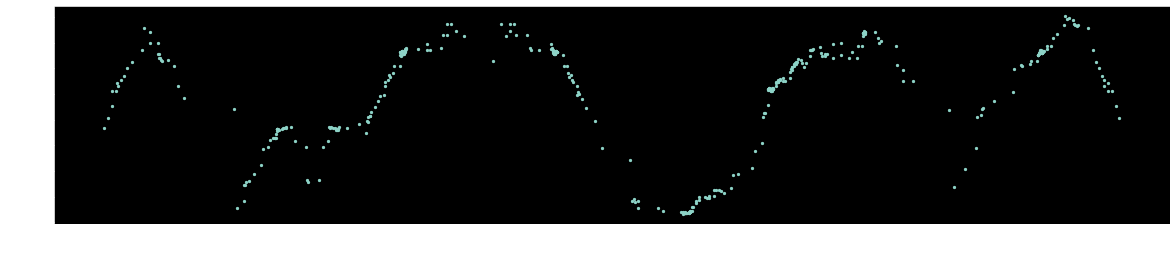

In [12]:
# Plot elevation profil
gdf_nodes_route2.plot(kind='scatter', x="cum_dist", y="elevation", marker='.', figsize=(20,4))